In [1]:
import numpy as np
import pandas as pd
import os

# to get all the captions of an image

In [28]:
def get_captions(filename):
    file = open(filename,'r')
    text = file.read()
    file.close()
    caption = {}
    data = text.split('\n')
    for i in range(len(data)-1):
        img,cap = data[i].split('\t')
        if img[:-2] not in caption:
            caption[img[:-2]]=[cap]
        else:
            caption[img[:-2]].append(cap)
    return caption
                
        
                   

In [29]:
captions = get_captions('Flickr8k_text/Flickr8k.token.txt')
captions

{'1000268201_693b08cb0e.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'T

# cleaning text

In [5]:
import re
def cleaning_text(captions):
    for img,cap in captions.items():
        for i in range(len(cap)):
            review = re.sub('[^a-zA-Z]',' ',cap[i])
            review = review.lower()
            review = review.split()
            review = [word for word in review if len(word) >1]
            review = ' '.join(review)
            captions[img][i] = review
    return captions

In [6]:
cleaned_captions = cleaning_text(captions)
cleaned_captions

{'1000268201_693b08cb0e.jpg': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70.jpg': ['black dog and spotted dog are fighting',
  'black dog and tri colored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8.jpg': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting',
  'young

# Build vocab of all unique words

In [7]:
def build_vocab(cleaned_captions):
    vocab = set()
    for img in cleaned_captions.keys():
        [vocab.update(d.split()) for d in cleaned_captions[img]]
    return vocab

In [8]:
vocab = build_vocab(cleaned_captions)
len(vocab)

8424

# All description in one file

In [9]:
def save_description(cleaned_captions,filename):
    desc = []
    for img ,cap in cleaned_captions.items():
        for c in cap:
            desc.append(img+'\t'+c)
    data = '\n'.join(desc)
    file = open(filename,'w')
    file.write(data)
    file.close()
    return

In [10]:
save_description(cleaned_captions,'descriptions.txt')

# Feature extracting from all images

In [11]:
from tensorflow.keras.applications.xception import Xception , preprocess_input 
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
from tensorflow.keras.utils import to_categorical
from pickle import dump,load
from tqdm import tqdm
from PIL import Image

In [12]:
def extract_features(directory):
    model = Xception(include_top=False ,pooling = 'avg')
    features = {}
    for img in tqdm(os.listdir(directory)):
        imgpath =  directory + '/' +img
        image  = Image.open(imgpath)
        image =  image.resize((299,299))
        image = np.expand_dims(image,axis=0)
        image = preprocess_input(image)
        feature = model.predict(image)
        features[img] = feature
    return features

In [13]:
features = extract_features('Flicker8k_Dataset')
dump(features,open('features.p','wb'))

83689472/83683744 [==============================] - 23s 0us/step


100%|██████████| 8091/8091 [40:04<00:00,  3.36it/s]  


In [14]:
len(features)

8091

# loading dataset for training the model

In [40]:
def load_images(filename1,filename2):
    file = open(filename1,'r')
    data = file.read()
    file.close()
    photos = data.split('\n')[:-1]
    captions = {}
    file2 = open(filename2,'r')
    desc = file2.read()
    file2.close()
    for line in desc.split('\n'):
        img ,cap = line.split('\t')
        if img in photos :
            if img not in captions:
                captions[img] = []
            cap = '<start> '+cap+' <end>'
            captions[img].append(cap)
    return captions

In [41]:
train_captions = load_images('Flickr8k_text/Flickr_8k.trainImages.txt','descriptions.txt')
train_captions

{'1000268201_693b08cb0e.jpg': ['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
  '<start> girl going into wooden building <end>',
  '<start> little girl climbing into wooden playhouse <end>',
  '<start> little girl climbing the stairs to her playhouse <end>',
  '<start> little girl in pink dress going into wooden cabin <end>'],
 '1001773457_577c3a7d70.jpg': ['<start> black dog and spotted dog are fighting <end>',
  '<start> black dog and tri colored dog playing with each other on the road <end>',
  '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
  '<start> two dogs of different breeds looking at each other on the road <end>',
  '<start> two dogs on pavement moving toward each other <end>'],
 '1002674143_1b742ab4b8.jpg': ['<start> little girl covered in paint sits in front of painted rainbow with her hands in bowl <end>',
  '<start> little girl is sitting in front of large painted rainbow <end>',
  '<sta

In [42]:
len(train_captions)

6000

In [43]:
def load_features(filename):
    file = open(filename,'r')
    data = file.read()
    file.close()
    photos = data.split('\n')[:-1]
    all_features = load(open('features.p','rb'))
    features = {k:all_features[k] for k in photos}
    return features


In [44]:
train_features = load_features('Flickr8k_text/Flickr_8k.trainImages.txt')
train_features

{'2513260012_03d33305cf.jpg': array([[0.        , 0.4481573 , 0.        , ..., 0.17757417, 0.00191514,
         0.00869671]], dtype=float32),
 '2903617548_d3e38d7f88.jpg': array([[0.17655917, 0.01287615, 0.15669015, ..., 0.07785615, 0.22157365,
         0.07919034]], dtype=float32),
 '3338291921_fe7ae0c8f8.jpg': array([[0.2878616 , 0.        , 0.        , ..., 0.        , 0.08850839,
         0.        ]], dtype=float32),
 '488416045_1c6d903fe0.jpg': array([[0.453643  , 0.        , 0.        , ..., 0.00685257, 0.        ,
         0.        ]], dtype=float32),
 '2644326817_8f45080b87.jpg': array([[0.00466416, 0.00331446, 0.02121828, ..., 0.07942974, 0.01354531,
         0.        ]], dtype=float32),
 '218342358_1755a9cce1.jpg': array([[0.07323251, 0.01431638, 0.11561771, ..., 0.11935557, 0.07156444,
         0.11425354]], dtype=float32),
 '2501968935_02f2cd8079.jpg': array([[1.10656120e-01, 1.73772569e-04, 3.46863627e-01, ...,
         1.25681665e-02, 1.08910583e-01, 3.87887686e-01]], 

In [45]:
train_features["2513260012_03d33305cf.jpg"]

array([[0.        , 0.4481573 , 0.        , ..., 0.17757417, 0.00191514,
        0.00869671]], dtype=float32)

# Tokenizing the vocab

In [46]:
from keras.preprocessing.text import Tokenizer

def create_tokenizer(train_descriptions):
    desc_list = []
    for img in train_descriptions.keys():
        [desc_list.append(d) for d in train_descriptions[img]]
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [47]:
tokenizer = create_tokenizer(train_captions)
dump(tokenizer,open('tokenizer.p','wb'))

In [48]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

7319

In [49]:
tokenizer.word_index

{'end': 1,
 'start': 2,
 'in': 3,
 'the': 4,
 'on': 5,
 'is': 6,
 'and': 7,
 'dog': 8,
 'with': 9,
 'man': 10,
 'of': 11,
 'two': 12,
 'white': 13,
 'black': 14,
 'boy': 15,
 'are': 16,
 'woman': 17,
 'girl': 18,
 'to': 19,
 'wearing': 20,
 'at': 21,
 'people': 22,
 'water': 23,
 'brown': 24,
 'red': 25,
 'young': 26,
 'an': 27,
 'his': 28,
 'blue': 29,
 'dogs': 30,
 'running': 31,
 'through': 32,
 'shirt': 33,
 'playing': 34,
 'while': 35,
 'down': 36,
 'ball': 37,
 'standing': 38,
 'little': 39,
 'grass': 40,
 'snow': 41,
 'child': 42,
 'person': 43,
 'jumping': 44,
 'over': 45,
 'three': 46,
 'sitting': 47,
 'field': 48,
 'front': 49,
 'holding': 50,
 'small': 51,
 'up': 52,
 'green': 53,
 'yellow': 54,
 'group': 55,
 'by': 56,
 'large': 57,
 'one': 58,
 'walking': 59,
 'her': 60,
 'men': 61,
 'children': 62,
 'air': 63,
 'into': 64,
 'near': 65,
 'mouth': 66,
 'beach': 67,
 'jumps': 68,
 'runs': 69,
 'another': 70,
 'for': 71,
 'street': 72,
 'from': 73,
 'its': 74,
 'riding': 75,


In [50]:
def max_length(captions):
    max_len = 0
    for img ,cap in captions.items(): 
        for c in cap:
            if max_len <len(c.split()):
                max_len = len(c.split())
    return max_len

In [51]:
max_cap_length = max_length(captions)
max_cap_length

38

# Create Data Generator

In [52]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [87]:
def data_generator(train_captions, train_features, tokenizer, max_cap_length):
    while(1):
        for img, cap in train_captions.items():
            #retrieve image features(2048 vector)
            feature = train_features[img][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_cap_length, cap, feature)
            yield([input_image , input_sequence],output_word)

In [88]:
def create_sequences(tokenizer,max_cap_length, cap , feature):
    X1, X2 ,y = list(),list(),list()
    for desc in cap:
        #encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq , out_seq = seq[:i],seq[i]
            in_seq = pad_sequences([in_seq],maxlen = max_cap_length)[0]
            out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    
    return np.array(X1), np.array(X2), np.array(y)

In [89]:
[a,b] , c = next(data_generator(train_captions, train_features, tokenizer, max_cap_length))
a.shape , b.shape , c.shape

((47, 2048), (47, 38), (47, 7319))

# Defining CNN & RNN model

In [90]:
from keras.utils import plot_model
from keras.models import Model, load_model
from keras.layers.merge import add 
from keras.layers import Input , Dense , LSTM, Embedding, Dropout

In [94]:
def define_model(vocab_size , max_cap_length):
    #features from cnn model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape = (2048,))
    fe1 = Dropout(0.3)(inputs1)
    fe2 = Dense(256,activation='relu')(fe1)
    
    #LSTM sequence model
    inputs2 = Input(shape = (max_cap_length,))
    se1 = Embedding(vocab_size , 256,mask_zero =True)(inputs2)
    se2 = Dropout(0.3)(se1)
    se3 = LSTM(256)(se2)
    
    # merge both models
    decoder1 = add([fe2,se3])
    decoder2 = Dense(256,activation='relu')(decoder1)
    
    #output layer
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    #Tie it together[image,seq] [word]
    model = Model(inputs = [inputs1,inputs2],outputs = outputs)
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
    
    # summarize model
    model.summary()
    
    #plot model
    plot_model(model, to_file = 'model.png',show_shapes= True)
    
    return model

In [95]:
# train our model
print('Dataset: ', len(train_captions))
print('Descriptions: train=', len(train_captions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_cap_length)

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7319
Description Length:  38


In [96]:
model = define_model(vocab_size , max_cap_length)
epochs = 10
steps = len(train_captions)

dirc = os.listdir(".")
dirc
if 'models' not in dirc :
    os.mkdir('models')
for i in range(epochs):
    generator = data_generator(train_captions , train_features , tokenizer ,max_cap_length)
    model.fit(generator ,epochs = 1 ,steps_per_epoch = steps, verbose = 1)
    model.save('models/model_'+str(i)+'.h5')

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 38, 256)      1873664     input_17[0][0]                   
__________________________________________________________________________________________________
dropout_14 (Dropout)            (None, 2048)         0           input_16[0][0]                   
____________________________________________________________________________________________

# Testing model

In [98]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [99]:
def test_extract_feature(filename, model):
    try:
        image = Image.open(filename)
    except:
        print('Invalid image')
    
    image = image.resize((299,299))
    image = np.array(image)
    if image.shape[2]==4:
        image = image[...,:3]
    image = np.expand_dims(image,axis=0)
    image = preprocess_input(image)
    feature = model.predict(image)
    return feature

In [100]:
def word_for_id(integer , tokenizer):
    for word , index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [101]:
def test_generate_desc(model, tokenizer, photo, max_cap_length):
    in_text = 'start'
    for i in range(max_cap_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen = max_cap_length )
        pred = model.predict([photo,sequence],verbose=0)
        pred= np.argmax(pred)
        word = word_for_id(pred,tokenizer)
        if word is None:
            break
        in_text += ' '+word
        if word == 'end':
            break
    return in_text



start man is climbing up very large snowy mountain end


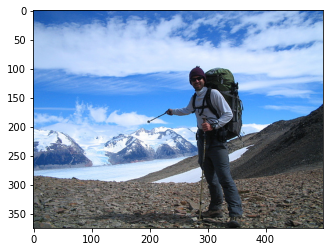

In [102]:
tokenizer = load(open('tokenizer.p','rb'))
model = load_model('models/model_9.h5')
xception_model = Xception(include_top =False , pooling ='avg')
img_path = 'Flicker8k_Dataset/54501196_a9ac9d66f2.jpg'
photo = test_extract_feature(img_path , xception_model)
img = Image.open(img_path)
description = test_generate_desc(model  , tokenizer , photo, max_cap_length)
print('\n')
print(description)
plt.imshow(img)